<a href="https://colab.research.google.com/github/yashodharatomar/credit_card_fraud_detection/blob/main/XGBoost_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using XGBoost, SMOTE, and threshold moving

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from xgboost import Booster
from xgboost import DMatrix

from sklearn import metrics

from datetime import datetime

file_link = "/content/drive/MyDrive/creditcard.csv"
dataDF = pd.read_csv(file_link, sep=",")


Feature Engineering

Creating a holdout set to prevent any information leakage into our test set.

In [ ]:
trainDF, testDF = train_test_split(dataDF, test_size=0.2, random_state=1234, stratify=dataDF[["Class"]])

tr_value_counts = trainDF["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the training set." % (tr_value_counts[1] * 100 / len(trainDF)))

tst_value_counts = testDF["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the test set." % (tst_value_counts[1] * 100 / len(testDF)))

Fraudulent transactions are 0.17% of the training set.
Fraudulent transactions are 0.17% of the test set.


Making the Amount and Hour attribute zero mean centered.

In [ ]:
trainDF_norm = trainDF.copy()

trainDF_norm["Amount"] = trainDF["Amount"].subtract(trainDF["Amount"].mean())
# trainDF_norm["Hour"] = trainDF["Hour"].subtract(trainDF["Hour"].mean())


testDF_norm = testDF.copy()

testDF_norm["Amount"] = testDF["Amount"].subtract(testDF["Amount"].mean())
# testDF_norm["Hour"] = testDF["Hour"].subtract(testDF["Hour"].mean())

trainDF = trainDF_norm
testDF = testDF_norm

Dropping the Time attribute as we will be using Hour instead.



In [ ]:
trainDF = trainDF.drop(["Time"], axis=1)
testDF = testDF.drop(["Time"], axis=1)


Splitting the independent and the class variables into separate data frames.



In [ ]:
X_train = trainDF.iloc[:, trainDF.columns != "Class"]
y_train = trainDF.iloc[:, trainDF.columns == "Class"]
X_test = testDF.iloc[:, testDF.columns != "Class"]
y_test = testDF.iloc[:, testDF.columns == "Class"]
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
135152,1.082410,-0.074595,1.395121,1.373155,-0.957702,0.076975,-0.624897,0.204656,0.860576,-0.248178,...,-0.170510,-0.011536,0.203804,0.062781,0.398966,0.298497,-0.399509,0.089284,0.038552,-76.75017
103706,1.012932,0.188189,1.614652,2.594349,-0.608548,0.838769,-0.682672,0.399546,-0.259848,0.597131,...,-0.138771,0.017388,0.217521,0.074358,0.230008,0.185481,-0.046162,0.058670,0.026582,-81.45017
231651,-0.700875,0.090423,1.540104,-3.114105,0.458284,0.430556,0.182614,0.195305,-1.230480,-0.503483,...,0.082503,-0.069127,-0.367488,-0.448596,-1.460857,0.627512,-0.475224,0.003550,0.026878,-76.25017
199939,-0.429842,-0.594603,0.676445,-2.603120,1.498860,4.231149,-1.079401,1.239169,-0.797602,-0.002607,...,-0.284917,-0.015413,0.213932,0.090396,0.694341,-0.697503,0.591872,0.158109,0.165911,-42.35017
103404,1.295579,1.011229,-3.192073,0.471632,3.350053,2.432852,0.189805,0.621685,-0.556724,-1.487450,...,0.086355,-0.263133,-0.825472,-0.245425,0.674759,1.010771,-0.279081,0.040506,0.090607,-83.26017


Using Synthetic Minority Over-sampling Technique (SMOTE) to resolve class imbalance.



In [ ]:
X_train_smote, y_train_smote = SMOTE(random_state=1234).fit_resample(X_train, y_train)

# Get value counts
smote_value_counts = y_train_smote["Class"].value_counts()

# Calculate the percentage of fraudulent transactions
fraudulent_percentage = smote_value_counts[1] * 100 / len(y_train_smote)

# Print the result
print("Fraudulent transactions are %.2f%% of the test set." % fraudulent_percentage)

Fraudulent transactions are 50.00% of the test set.


Model training

Training a XGBoost classifier, using the oversampled training set.

First, we define a function that will perform a grid search for the optimal hyperparameters of the classifier. The highlights of the function are as follows:

1.We do a parameter search over the hyperparameters given in params.

2.The cross-validation strategy for each model uses 3 folds in a stratified KFold.

3.The metric the models in the search are evaluated on is the Area Under the Receiver Operating Characteristic Curve (ROC AUC).

The function prints the parameters that yield the highest AUC score and returns the parameters of the best estimator as its output

In [ ]:
def xgboost_search(X, y, search_verbose=1):

    params = {
        "gamma":[0.5, 1, 1.5, 2, 5],
        "max_depth":[3,4,5,6],
        "min_child_weight": [100],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "learning_rate": [0.1, 0.01, 0.001]
    }

    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)

    grid_search.fit(X, y)

    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

After xgboost_search goes through all possible estimators it will print the parameters used for the best performing one, and will return an XGBClassifier object that we can use to check how well the model generalises.

In [ ]:
rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 5000)
model_params = xgboost_search(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,])

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best estimator: 
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=100, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 0.99


Now we have the set of parameters that produces the highest score, we can use them to train a model on the complete oversampled training set.

In [ ]:
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**model_params)
model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=100, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Model evaluation.

We use an ROC AUC curve for evaluating how well our model performs on the holdout set (X_test, y_test).

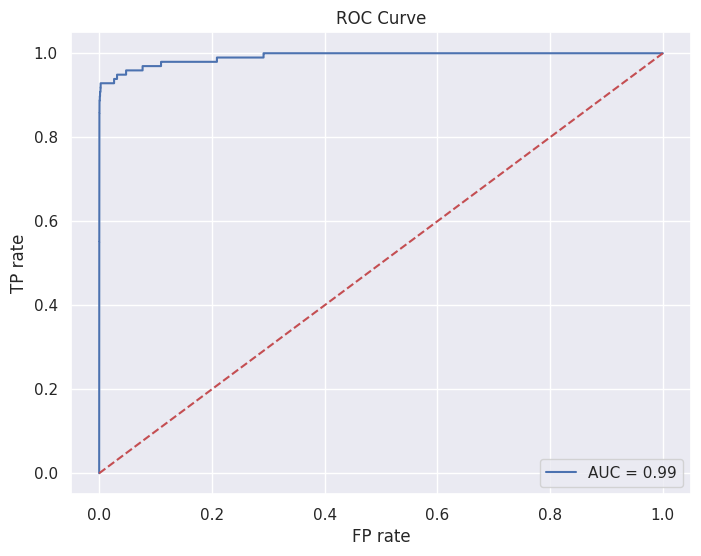

In [ ]:
y_pred = model.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)

plt.figure(figsize=(8, 6))

plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")

plt.ylabel("TP rate")
plt.xlabel("FP rate")

plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

There is an extra factor that comes into play in fraud detection, which is that the cost of one type of misclassification is substantially higher than the other. In other words, classifying a legitimate transaction as fraud is inconvenient at best, but letting a fraudulent transaction slip through has more dire consequences. In this context, offsetting the threshold in a way that reduces the false negatives at the expense of false positives becomes a viable strategy.

Selecting the optimal threshold value can be performed in a number of ways. Looking at the ROC curve, we can intuitively see that the best performance (misclassification costs aside) would be yield by the threshold that puts us in the top left section of the curve (i.e. TP rate is high, FP rate is low). With this criterion in mind, we can define a distance metric to the top left corner of the curve and find a threshold that minimises it.

In [ ]:
t_opt_idx = np.argmax(tp_r - fp_r)
t_opt = t[t_opt_idx]
print("Threshold value is: %.2f" % t_opt)

Threshold value is: 0.75


We also manually inspect the confusion matrices at different threshold values.



Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

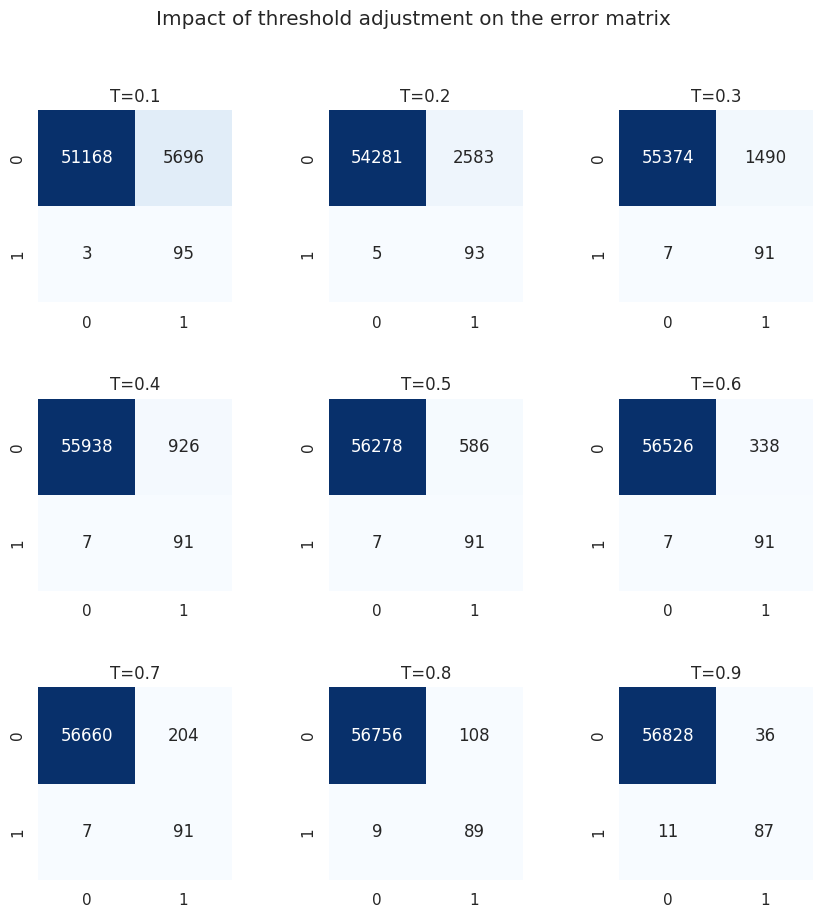

In [ ]:
y_pred = model.predict_proba(X_test)[:,1]

fig, axes = plt.subplots(3,3, figsize=(10,10))

for t, ax in enumerate(axes.flat):
    threshold = (t+1)/10

    y_pred_int = (y_pred > threshold).astype(int)
    c_matrix = metrics.confusion_matrix(y_test, y_pred_int)
    sns.heatmap(c_matrix, annot=True, cmap="Blues", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.1f" % threshold)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")

Looking at the plot above, we can indeed confirm that T=0.8 gives the best interpretation. The false negatives and false positives are both low. Increasing the threshold further leads to missing more fraudulent transactions, and reducing it lower almost doubles the number false positives.